![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Impacto de la alimentación sobre la salud de las personas
## Juan Francisco Tamaral Moreno

### Tabla de Contenidos
* [1. Introducción](#introduccion)
    * [1.1. Importar Librerias](#librerias)
    * [1.2. Importar datos](#data)
        * [1.2.1. Consumo de alimentos por CC.AA.](#consumos)
        * [1.2.2. Población por CC.AA.](#poblacion)
        * [1.2.3. Muertes por diabetes mellitus por CC.AA](#diabetes)


       
* [2. Extracción y limpieza de los datos](#etl)
    * [2.1. Selección de las familias de alimentos relacionadas con la diabetes](#familias_diabetes)
    * [2.2. Normalización de consumos de alimentos con la poblacion de las CC.AA.](#normalizacion_consumos)
    * [2.3. Transformación dataset de muertes por diabetes mellitus por CC.AA.](#etl_diabetes)


       
* [3. Análisis de la alimentación en España](#analisis)
    * [3.1. Selección de alimentos relacionados con la dieta mediterránea](#dieta_mediterranea)
    * [3.2. Clustering de CC.AA. según el consumo de alimentos relacionados con la dieta mediterránea](#clustering)
    * [3.3. Interpretación de los resultados](#resultados)

# 1. Introducción <a class="anchor" id="introduccion"></a>

## 1.1. Importar Librerías<a class="anchor" id="librerias"></a>

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

import geopandas as gpd

## 1.2. Importar datos <a class="anchor" id="data"></a>

### 1.2.1. Consumos por CC.AA. <a class="anchor" id="consumos"></a>

In [2]:
PATH_COMUNIDADES = 'data/comunidades/'

In [3]:
# Leemos los nombres de los ficheros
paths_comunidades = [path for path in os.listdir(PATH_COMUNIDADES) if path.endswith('.xlsx')]

# Creamos una lista para ir añadiendo los dataframes leidos
dfs = list()

for path_comunidad in paths_comunidades:
    # Extraemos el nombre de la comunidad
    nombre_comunidad = os.path.splitext(path_comunidad)[0]

    # Leemos el fichero, reseteamos el index y le cambiamos el nombre de la columna a ID
    fichero = pd.read_excel('./data/comunidades/'+path_comunidad).reset_index(drop=True).rename(columns={'Unnamed: 0': 'ID'})

    # Descartamos las filas donde el la columna BIO no es nula y asignamos el nombre de la comunidad a una nueva columna.
    fichero_sin_bio = fichero[fichero['SEGMENTO BIO'].isna()].reset_index(drop=True).assign(COMUNIDAD=nombre_comunidad)

    # Añadimos el fichero leido a nuestra lista de dataframes
    dfs.append(fichero_sin_bio)

# Montamos el dataframe final
df_comunidades = pd.concat(dfs, ignore_index=True)

# Eliminamos la columna SEGMENTO BIO
df_comunidades.drop('SEGMENTO BIO', axis=1, inplace=True)

# Cambiamos el orden de la columna COMUNIDAD
cols = df_comunidades.columns.tolist()
cols = cols[:5] + cols[-1:] + cols[5:-1]
df_comunidades = df_comunidades[cols]

In [4]:
df_comunidades.head()

,ID,SECTOR,SECCION,CATEGORIA,FAMILIA,COMUNIDAD,SEMANA 40-16,SEMANA 41-16,SEMANA 42-16,SEMANA 43-16,...,SEMANA 34-19,SEMANA 35-19,SEMANA 36-19,SEMANA 37-19,SEMANA 38-19,SEMANA 39-19,SEMANA 40-19,SEMANA 41-19,SEMANA 42-19,SEMANA 43-19
0,TOTAL PGC,NaN,NaN,NaN,NaN,Ceuta_y_Melilla,0.0,0.0,0.0,0.0,...,2652.71,2853.52,2699.68,2703.08,2484.19,2853.67,2844.06,2412.15,2559.18,2647.53
1,ALIM. Y BEBIDAS,ALIM. Y BEBIDAS,NaN,NaN,NaN,Ceuta_y_Melilla,0.0,0.0,0.0,0.0,...,1328.36,1421.87,1364.16,1405.32,1269.16,1457.10,1477.37,1288.87,1375.99,1442.49
2,ALIM.SECA,ALIM. Y BEBIDAS,ALIM.SECA,NaN,NaN,Ceuta_y_Melilla,0.0,0.0,0.0,0.0,...,704.00,782.74,760.74,791.09,717.49,829.03,829.07,739.01,813.17,891.25
3,ACEITE,ALIM. Y BEBIDAS,ALIM.SECA,ACEITE,NaN,Ceuta_y_Melilla,0.0,0.0,0.0,0.0,...,60.80,72.97,67.83,71.55,62.32,73.07,76.68,61.45,60.28,63.69
4,GIRASOL..,ALIM. Y BEBIDAS,ALIM.SECA,ACEITE,GIRASOL..,Ceuta_y_Melilla,0.0,0.0,0.0,0.0,...,18.18,20.78,20.41,20.16,18.68,21.06,22.47,16.94,17.49,19.44


### 1.2.2. Población por CC.AA. <a class="anchor" id="poblacion"></a>

In [5]:
PATH_POBLACION = './data/poblacion/'

In [6]:
df_poblacion = pd.read_excel(PATH_POBLACION+'poblacion_comunidades.xlsx', skiprows=1).set_index('CC.AA.')

In [7]:
df_poblacion

,2016,2017,2018,2019,2020
CC.AA.,,,,,
Ceuta_y_Melilla,170545,171079,171528,171264,171278
La_Rioja,315794,315381,315675,316798,313914
Pais_Vasco,2189534,2194158,2199088,2207776,2220504
Navarra,640647,643234,647554,654214,661197
Murcia,1464847,1470273,1478509,1493898,1511251
Madrid,6466996,6507184,6578079,6663394,6779888
Galicia,2718525,2708339,2701743,2699499,2701819
Extremadura,1087778,1079920,1072863,1067710,1063987
C_Valenciana,4959968,4941509,4963703,5003769,5057353


###  1.2.3. Muertes por diabetes mellitus por CC.AA <a class="anchor" id="diabetes"></a>

In [8]:
# Guardamos el path donde tenemos los datos de las enfermedades
PATH_ENFERMEDADES = './data/enfermedades/'

In [9]:
# Creamos el DataFrame con los datos de la tasa de muertes por comunidades
df_muertos_diabetes = pd.read_excel(PATH_ENFERMEDADES + 'diabetes.xlsx', skiprows=1).set_index('CC.AA.')

In [10]:
# Comprobamos que se ha cargado correctamente el DataFrame
df_muertos_diabetes

,2016,2017,2018,2019,2020
CC.AA.,,,,,
Ceuta_y_Melilla,50.36,35.33,27.14,20.33,47.11
La_Rioja,15.88,15.51,19.18,15.20,15.82
Pais_Vasco,15.19,13.03,15.14,15.07,16.65
Navarra,20.41,20.21,16.13,15.77,16.34
Murcia,20.92,25.17,21.24,22.40,30.91
Madrid,10.90,10.49,10.23,8.28,10.03
Galicia,16.32,14.40,12.66,11.08,12.88
Extremadura,19.58,17.68,17.88,16.88,22.17
C_Valenciana,19.39,20.06,25.27,25.50,28.49


# 2. Extracción y limpieza de datos <a class="anchor" id="etl"></a>

## 2.1. Selección de las familias de alimentos relacionadas con la diabetes <a class="anchor" id="familias_diabetes"></a>

Nuestros datos están clasificados de la siguiente forma:

SECTOR > SECCION > CATEGORIA > FAMILIA

El objetivo es ir recorriendo cada agrupación para descartar familias de alimentos que no estén relacionadas con la diabetes.

In [11]:
# Sacamos la lista de todos los valores de cada sector, sección, categoría y familia de alimentos
lista_sectores = list(df_comunidades[~df_comunidades['SECTOR'].isna()]['SECTOR'].unique())
lista_secciones = list(df_comunidades[~df_comunidades['SECCION'].isna()]['SECCION'].unique())
lista_categorias = list(df_comunidades[~df_comunidades['CATEGORIA'].isna()]['CATEGORIA'].unique())
lista_familias = list(df_comunidades[~df_comunidades['FAMILIA'].isna()]['FAMILIA'].unique())

### Sectores relacionados con diabetes

In [12]:
# Copiamos la primera lista para modificarla
lista_sectores_diabetes = lista_sectores.copy()

# Eliminamos los sectores que no están relacionados con la diabetes
lista_sectores_diabetes.remove('DROGUERIA Y PERFUMERIA')

# Mostramos los sectores seleccionados
lista_sectores_diabetes

['ALIM. Y BEBIDAS', 'PROD.FRESCOS']

### Secciones relacionadas con diabetes

In [13]:
# Seleccionamos las secciones que hay dentro de de los sectores seleccionados en lista_sectores_diabetes
lista_secciones_sectores_diabetes = list(df_comunidades.loc[df_comunidades['SECTOR'].isin(lista_sectores_diabetes), 'SECCION'].unique())[1:]

# Copiamos la lista de los secciones de los sectores relacionados con la diabetes
lista_secciones_diabetes = lista_secciones_sectores_diabetes.copy()

# Creamos una lista de las secciones a eliminar
secciones_sin_diabetes = ['CONSERVAS', 'CHARCUTERIA', 'PL. COCINADOS Y PRECOCINADOS', 'QUESOS']

# Eliminamos las secciones que no están relacionadas con la diabetes
for i in range(len(secciones_sin_diabetes)):
    lista_secciones_diabetes.remove(secciones_sin_diabetes[i])

# Mostramos las secciones seleccionadas
lista_secciones_diabetes

['ALIM.SECA', 'BEBIDAS', 'LECHE Y BATIDOS', 'CONGELADOS', 'DERV.LACTEOS']

### Categorías relacionadas con diabetes

In [14]:
# Seleccionamos las categorias que hay dentro de de los secciones seleccionados en lista_secciones_diabetes
lista_categorias_secciones_diabetes = list(df_comunidades.loc[df_comunidades['SECCION'].isin(lista_secciones_diabetes), 'CATEGORIA'].unique())[1:]

# Copiamos la lista de los categorias de las secciones relacionados con la diabetes
lista_categorias_diabetes = lista_categorias_secciones_diabetes.copy()

# Creamos una lista de las categorias a eliminar
categorias_sin_diabetes = [
    'ACEITE', 'ADITIVOS COCINA', 'ALIMENTOS INFANTILES', 'ALIMENTOS MASCOTAS', 'APERITIVOS', 'ARROZ', 'CAFES', 'DIETETICOS', 'FRUTOS SECOS',
    'INFUSIONES', 'LEGUMBRES SECAS', 'PANADERIA INDUSTRIAL', 'PASTAS', 'SOPAS Y DESHIDRATADOS', 'AGUAS', 'CERVEZA', 'ESPUMOSOS', 'VINOS',
    'LECHE LIQUIDA Y BEBIDAS VEGETALES', 'PESCADO CONGELADO', 'PESCADO PREPARADO CONGELADO', 'PLATOS PREPARADOS CONGELADOS', 'VERDURAS CONGELADAS',
    'MANTEQUILLA', 'MARGARINA', 'QUESO TIPO PETIT'
]

# Eliminamos las categorias que no están relacionadas con la diabetes
for i in range(len(categorias_sin_diabetes)):
    lista_categorias_diabetes.remove(categorias_sin_diabetes[i])

# Mostramos las categorías seleccionadas
lista_categorias_diabetes

['AZUCAR Y EDULCORANTES',
 'BOLLERIA INDUSTRIAL',
 'CACAO',
 'CEREALES DESAYUNO',
 'CHOCOLATES',
 'DULCES NAVIDENOS',
 'GALLETAS',
 'GOLOSINAS',
 'REPOSTERIA',
 'SALSAS',
 'BEBIDAS ALCOHOLICAS',
 'BEBIDAS REFRESCANTES',
 'ZUMOS',
 'BATIDOS',
 'HORCHATA.',
 'LECHE NO LIQUIDA',
 'HELADOS',
 'OTROS CONGELADOS',
 'NATA',
 'POSTRES PREPARADOS',
 'YOGURES']

### Familias de alimentos relacionadas con diabetes

In [15]:
# Seleccionamos las familias de alimentos que hay dentro de de las categorias seleccionados en lista_categorias_diabetes
lista_familias_categorias_diabetes = list(df_comunidades.loc[df_comunidades['CATEGORIA'].isin(lista_categorias_diabetes), 'FAMILIA'].unique())[1:]

# Copiamos la lista de las familias de alimentos de las categorias relacionados con la diabetes
lista_familias_diabetes = lista_familias_categorias_diabetes.copy()

# Creamos una lista de las categorias a eliminar
famlias_sin_diabetes = [
    'EDULCORANTE', 'LEVADURA', 'L.EVAPORADA', 'L.POLVO', 'BASES PIZZA', 'CHURROS', 'FRUTAS', 'HIELO', 'HOJALDRES MASAS RELLENAS', 'HOJALDRES SIN RELLENAR',
    'NATA', 'YOGUR NATURAL'
]

# Eliminamos las familias que no están relacionadas con la diabetes
for i in range(len(famlias_sin_diabetes)):
    lista_familias_diabetes.remove(famlias_sin_diabetes[i])

# Lista de las categorias relacionadas con la diabetes. Mostramos la cantidad de familias de alimentos que hemos seleccionado
len(lista_familias_diabetes)

120

## 2.2. Normalización de consumos de alimentos con la poblacion de las CC.AA. <a class="anchor" id="normalizacion_consumos"></a>

In [16]:
# Creamos un dataset de las familias de alimentos que tienen relación con la diabetes
df_diabetes = df_comunidades[df_comunidades['FAMILIA'].isin(lista_familias_diabetes)].groupby('COMUNIDAD').sum().T

# Editamos el índice para que tenga un formato adecuado para ser formateado a fecha (quitamos 'SEMANA', 1 para que la semana empiece en lunes, la semana y el año)
df_diabetes.index = '1 ' + df_diabetes.index.str[-5:-3] + ' ' + df_diabetes.index.str[-2:]
df_diabetes.index = pd.to_datetime(df_diabetes.index, format="%w %W %y")

# Cambiamos la granularidad a mensual
df_diabetes = df_diabetes.groupby(pd.Grouper(freq='M')).sum()

In [17]:
# Dividimos el DF para cada año
df_diabetes_2017 = df_diabetes['2017':'2017']
df_diabetes_2018 = df_diabetes['2018':'2018']
df_diabetes_2019 = df_diabetes['2019':'2019']

In [18]:
# Usamos la función apply para dividir los datos por la población de cada comunidad por cada 100000 habitantes
df_diabetes_2017_normalizado = df_diabetes_2017.apply(lambda x: x / df_poblacion['2017'][x.name] * 100000)
df_diabetes_2018_normalizado = df_diabetes_2018.apply(lambda x: x / df_poblacion['2018'][x.name] * 100000)
df_diabetes_2019_normalizado = df_diabetes_2019.apply(lambda x: x / df_poblacion['2019'][x.name] * 100000)

In [19]:
# Unimos el DF con los valores ya normalizados
df_diabetes_normalizado = pd.concat([df_diabetes_2017_normalizado, df_diabetes_2018_normalizado, df_diabetes_2019_normalizado])

In [20]:
fig = px.line(
    df_diabetes_normalizado,
    title='Consumo normalizado de alimentos relacionados con la diabetes por CCAA',
    labels = {
        'index' : 'Tiempo',
        'value' : 'Consumo / Población * 100'
    }
)
fig.show()

## 2.3. Transformación dataset de muertes por diabetes mellitus por CC.AA. <a class="anchor" id="etl_diabetes"></a>

Los datos de diabetes mellitus que tenemos se refieren a la *** Tasa de mortalidad ajustada por diabetes mellitus, por 100 000 hab. ***

Por lo tanto para obtener los datos aproximados de muertes tenemos que dividir la población de cada CC.AA entre 100.000 y multiplicar por la tasa.

El objetivo de este punto es transformar el dataset para que tenga una granularidad similar a la de los datos de consumos.

In [21]:
#df_aux = df_muertos_diabetes.set_index('CC.AA.').T
fig = px.line(
    df_muertos_diabetes.T,
    title='Tasa ajustada de muertes por diabetes mellitus por CC.AA.',
    labels = {
        'index' : 'Tiempo',
        'value' : 'Tasa de muertes (*Poblacion / 100.000)'
    }
)
fig.show()

In [22]:
# Eliminamos el año 2016
df_muertos_diabetes.drop(['2016'], axis=1, inplace=True)

# Transponemos la tabla
df_muertos_diabetes = df_muertos_diabetes.T

# Cambiamos el index a Datetime
df_muertos_diabetes.index = pd.to_datetime(df_muertos_diabetes.index, format="%Y")

# Cambiamos la granularida a mensual con un backfill
df_muertos_diabetes = df_muertos_diabetes.resample('M').bfill()

# Eliminamos las 3 ultimas filas para que el último dato sea de Octubre de 2019, igual que los datos de consumos
df_muertos_diabetes.drop(df_muertos_diabetes.tail(3).index , axis=0, inplace=True)

# Mostramos el resultado de nuestro dataset
df_muertos_diabetes.head()

CC.AA.,Ceuta_y_Melilla,La_Rioja,Pais_Vasco,Navarra,Murcia,Madrid,Galicia,Extremadura,C_Valenciana,Catalunya,Castilla_La_Mancha,Castilla_y_Leon,Cantabria,Canarias,Baleares,Asturias,Aragon,Andalucia
2017-01-31,27.14,19.18,15.14,16.13,21.24,10.23,12.66,17.88,25.27,19.91,18.72,19.46,13.06,23.11,24.07,19.93,20.84,20.95
2017-02-28,27.14,19.18,15.14,16.13,21.24,10.23,12.66,17.88,25.27,19.91,18.72,19.46,13.06,23.11,24.07,19.93,20.84,20.95
2017-03-31,27.14,19.18,15.14,16.13,21.24,10.23,12.66,17.88,25.27,19.91,18.72,19.46,13.06,23.11,24.07,19.93,20.84,20.95
2017-04-30,27.14,19.18,15.14,16.13,21.24,10.23,12.66,17.88,25.27,19.91,18.72,19.46,13.06,23.11,24.07,19.93,20.84,20.95
2017-05-31,27.14,19.18,15.14,16.13,21.24,10.23,12.66,17.88,25.27,19.91,18.72,19.46,13.06,23.11,24.07,19.93,20.84,20.95


# 3. Análisis de la alimentación en España <a class="anchor" id="analisis"></a>

Ya que no podemos relacionar directamente la alimentación con las muertes por diabetes, vamos a tratar de analizar cómo se alimenta España para ver si hay diferencias por comunidades.

Para ello seleccionaremos los alimentos que consideramos que están dentro de la llamada "Dieta Mediterránea".

## 3.1. Selección de alimentos relacionados con la dieta mediterránea <a class="anchor" id="dieta_mediterranea"></a>

In [23]:
# Recuperamos las listas de todos los valores de cada sector, sección, categoría y familia de alimentos
lista_sectores = list(df_comunidades[~df_comunidades['SECTOR'].isna()]['SECTOR'].unique())
lista_secciones = list(df_comunidades[~df_comunidades['SECCION'].isna()]['SECCION'].unique())
lista_categorias = list(df_comunidades[~df_comunidades['CATEGORIA'].isna()]['CATEGORIA'].unique())
lista_familias = list(df_comunidades[~df_comunidades['FAMILIA'].isna()]['FAMILIA'].unique())

### Sectores dieta mediterránea

In [24]:
# Copiamos la primera lista para modificarla
lista_sectores_dieta_mediterranea = lista_sectores.copy()

# Eliminamos los sectores que no están relacionados con la dieta mediterránea
lista_sectores_dieta_mediterranea.remove('DROGUERIA Y PERFUMERIA')

# Mostramos los sectores seleccionados
lista_sectores_dieta_mediterranea

['ALIM. Y BEBIDAS', 'PROD.FRESCOS']

### Secciones dieta mediterránea

In [25]:
# Seleccionamos las secciones que hay dentro de de los sectores seleccionados en lista_sectores_dieta_mediterranea
lista_secciones_sectores_dieta_mediterranea = list(df_comunidades.loc[df_comunidades['SECTOR'].isin(lista_sectores_dieta_mediterranea), 'SECCION'].unique())[1:]

# Copiamos la lista de los secciones de los sectores relacionados con la dieta mediterránea
lista_secciones_dieta_mediterranea = lista_secciones_sectores_dieta_mediterranea.copy()

# Creamos una lista de las secciones a eliminar
secciones_a_descartar = ['LECHE Y BATIDOS', 'CONGELADOS', 'PL. COCINADOS Y PRECOCINADOS']

# Eliminamos las secciones que no están relacionadas con la dieta mediterránea
for i in range(len(secciones_a_descartar)):
    lista_secciones_dieta_mediterranea.remove(secciones_a_descartar[i])

# Mostramos las secciones seleccionadas
lista_secciones_dieta_mediterranea

['ALIM.SECA', 'BEBIDAS', 'CONSERVAS', 'CHARCUTERIA', 'DERV.LACTEOS', 'QUESOS']

### Categorías dieta medieterránea

In [26]:
# Seleccionamos las categorias que hay dentro de de los secciones seleccionados en lista_secciones_dieta_mediterranea
lista_categorias_secciones_dieta_mediterranea = list(df_comunidades.loc[df_comunidades['SECCION'].isin(lista_secciones_dieta_mediterranea), 'CATEGORIA'].unique())[1:]

# Copiamos la lista de los categorias de las secciones relacionados con la dieta mediterránea
lista_categorias_dieta_mediterranea = lista_categorias_secciones_dieta_mediterranea.copy()

# Creamos una lista de las categorias a eliminar
categorias_a_eliminar = [
    'ALIMENTOS INFANTILES', 'ALIMENTOS MASCOTAS', 'AZUCAR Y EDULCORANTES', 'BOLLERIA INDUSTRIAL', 'CACAO', 'CEREALES DESAYUNO', 'CHOCOLATES', 'DIETETICOS',
    'DULCES NAVIDENOS', 'GALLETAS', 'GOLOSINAS', 'INFUSIONES', 'REPOSTERIA', 'BEBIDAS ALCOHOLICAS', 'BEBIDAS REFRESCANTES', 'CONSERVAS DE CARNE Y PATES',
    'CONSERVAS DE FRUTAS Y DULCES', 'PATES REFRIGERADOS', 'SALCHICHAS REFRIGERADAS', 'MANTEQUILLA', 'MARGARINA'
]

# Eliminamos las categorias que no están relacionadas con la dieta mediterránea
for i in range(len(categorias_a_eliminar)):
    lista_categorias_dieta_mediterranea.remove(categorias_a_eliminar[i])

# Mostramos las categorías seleccionadas
lista_categorias_dieta_mediterranea

['ACEITE',
 'ADITIVOS COCINA',
 'APERITIVOS',
 'ARROZ',
 'CAFES',
 'FRUTOS SECOS',
 'LEGUMBRES SECAS',
 'PANADERIA INDUSTRIAL',
 'PASTAS',
 'SALSAS',
 'SOPAS Y DESHIDRATADOS',
 'AGUAS',
 'CERVEZA',
 'ESPUMOSOS',
 'VINOS',
 'ZUMOS',
 'ACEITUNAS Y ENCURT',
 'CONSERVAS DE PESCADO',
 'CONSERVAS VEGETALES',
 'PLATOS PREPARADOS CONSERVA',
 'AHUMADOS',
 'CHARCUTERIA',
 'SALAZONES',
 'SOBRASADA',
 'NATA',
 'POSTRES PREPARADOS',
 'QUESO TIPO PETIT',
 'YOGURES',
 'QUESO AZUL',
 'QUESO BOLA',
 'QUESO FRESCO',
 'QUESO FUNDIDO',
 'QUESO PASTA BLANDA',
 'QUESO RALLADO',
 'QUESO TRADICIONAL',
 'QUESOS BLANCOS PASTEURIZADOS',
 'REQUESON',
 'RESTO QUESOS NATURALES']

In [27]:
# Seleccionamos las familias de alimentos que hay dentro de de las categorias seleccionados en lista_categorias_dieta_mediterranea
lista_familias_categorias_dieta_mediterranea = list(df_comunidades.loc[df_comunidades['CATEGORIA'].isin(lista_categorias_dieta_mediterranea), 'FAMILIA'].unique())[1:]

# Copiamos la lista de las familias de alimentos de las categorias relacionados con la dieta mediterránea
lista_familias_dieta_mediterranea = lista_familias_categorias_dieta_mediterranea.copy()

# Creamos una lista de las familias a eliminar
familias_a_eliminar = [
    'RESTO ACEITES', 'PALOMITAS DE MAIZ', 'CAFE SOLUBLE', 'SUCEDANEOS DE CAFE', 'FRUTA SECA', 'BARBACOA', 'KETCHUP', 'MEXICANA', 'PICANTES', 'RESTO SALSAS',
     'SALSAS DESHIDRATADAS', 'PL.PREP.DESHIDRATADOS', 'CON GAS', 'CHAMPAGNE', 'VINOS DE LICOR', 'NECTAR', 'REFRIGERADOS Y SMOOTHIES', 'VITAMIN./C/ADITIVO',
     'PL.CONS.BASE CARNE', 'PL.CONS.BASE PASTA Y ARROZ', 'RESTO PLATOS PREPARADOS', 'A.RESTO' 
]

# Eliminamos las familias que no están relacionadas con la dieta mediterránea
for i in range(len(familias_a_eliminar)):
    lista_familias_dieta_mediterranea.remove(familias_a_eliminar[i])

# Lista de las categorias relacionadas con la dieta mediterránea. Mostramos la cantidad de familias de alimentos que hemos seleccionado
len(lista_familias_dieta_mediterranea)

112

### Creamos el dataframe para la dieta mediterránea

In [28]:
# Creamos un dataset de las familias de alimentos que tienen relación con la diabetes
df_dieta_mediterranea = df_comunidades[df_comunidades['FAMILIA'].isin(lista_familias_dieta_mediterranea)].groupby('COMUNIDAD').sum().T

# Editamos el índice para que tenga un formato adecuado para ser formateado a fecha (quitamos 'SEMANA', 1 para que la semana empiece en lunes, la semana y el año)
df_dieta_mediterranea.index = '1 ' + df_dieta_mediterranea.index.str[-5:-3] + ' ' + df_dieta_mediterranea.index.str[-2:]
df_dieta_mediterranea.index = pd.to_datetime(df_dieta_mediterranea.index, format="%w %W %y")

# Cambiamos la granularidad a mensual
df_dieta_mediterranea = df_dieta_mediterranea.groupby(pd.Grouper(freq='M')).sum()

In [29]:
# Dividimos el DF para cada año
df_dieta_mediterranea_2017 = df_dieta_mediterranea['2017':'2017']
df_dieta_mediterranea_2018 = df_dieta_mediterranea['2018':'2018']
df_dieta_mediterranea_2019 = df_dieta_mediterranea['2019':'2019']

In [30]:
# Usamos la función apply para dividir los datos por la población de cada comunidad por cada 100000 habitantes
df_dieta_mediterranea_2017_normalizado = df_dieta_mediterranea_2017.apply(lambda x: x / df_poblacion['2017'][x.name] * 100000)
df_dieta_mediterranea_2018_normalizado = df_dieta_mediterranea_2018.apply(lambda x: x / df_poblacion['2018'][x.name] * 100000)
df_dieta_mediterranea_2019_normalizado = df_dieta_mediterranea_2019.apply(lambda x: x / df_poblacion['2019'][x.name] * 100000)

In [31]:
# Unimos el DF con los valores ya normalizados
df_dieta_mediterranea_normalizado = pd.concat([df_dieta_mediterranea_2017_normalizado, df_dieta_mediterranea_2018_normalizado, df_dieta_mediterranea_2019_normalizado])

In [32]:
fig = px.line(
    df_dieta_mediterranea_normalizado,
    title='Consumo normalizado de alimentos relacionados con la dieta mediterránea (por CCAA)',
    labels = {
        'index' : 'Años',
        'value' : 'Consumo / 100.000 hab.'
    }
)
fig.show()

In [33]:
fig = px.bar(
    df_dieta_mediterranea_normalizado.sum().sort_values(),
    title='Consumo total de alimentos relacionados con la dieta mediterránea (por CCAA) normalizado.',
    labels = {
        'COMUNIDAD' : 'CC.AA',
        'value' : 'Consumo / 100.000 hab.'
    }
)
fig.show()

## 3.2. Clustering de CC.AA. según el consumo de alimentos relacionados con la dieta mediterránea <a class="anchor" id="clustering"></a>

Vamos a usar un algoritmo de clustering que nos va a hacer agrupaciones de CC.AA. según el consumo de las familias de alimentos que hemos relacionado con la dieta mediterránea.

### Creamos el dataframe

In [34]:
# Filtramos las familias de alimentos seleccionadas anteriormente y eliminamos las columnas que no necesitamos
df_clustering = df_comunidades[df_comunidades['FAMILIA'].isin(lista_familias_dieta_mediterranea)].drop(['ID', 'SECTOR', 'SECCION', 'CATEGORIA'], axis=1)


# Creamos la columna TOTAL con la suma de todos los consumos de los alimentos
df_clustering['TOTAL'] = df_clustering[df_clustering.columns[2:]].sum(axis=1)

#Nos quedamos con las columnas que necesitamos
df_clustering = df_clustering[['FAMILIA', 'COMUNIDAD', 'TOTAL']]

# Pivotamos la tabla para que nos quede el formato que necesitamos para hacer el clustering
df_clustering = df_clustering.pivot(index='COMUNIDAD', columns='FAMILIA', values='TOTAL')

# Eliminamos ceuta y melilla ya que la muestra de datos no parece correcta, por ser demasiado baja.
df_clustering.drop('Ceuta_y_Melilla', inplace=True)

### Normalización y escalado de los datos

In [35]:
# Dividimos el consumo por la población de cada comunidad / 100.000 habitantes
df_clustering_normalizado = df_clustering.T.apply(lambda x: x / df_poblacion['2020'][x.name] * 100000).T

In [36]:
# Creamos una instancia de StandardScaler
scaler = StandardScaler()

# Escalamos el dataframe
df_clustering_scaled = scaler.fit_transform(df_clustering_normalizado) 

### Búsqueda del número óptimo de clusters

#### Método del codo

In [37]:
distortions = []
K = range(1,10)

for cluster_size in K:
    kmeans = KMeans(n_clusters=cluster_size, init='k-means++')
    kmeans = kmeans.fit(df_clustering_scaled)
    distortions.append(kmeans.inertia_)
    
df = pd.DataFrame({'Clusters': K, 'Distortions': distortions})
fig = (px.line(df, x='Clusters', y='Distortions', template='seaborn', title='Método del codo')).update_traces(mode='lines+markers')
fig.show()

#### Análisis de la silueta

In [38]:
silhouette_scores = []
K = range(2,10)

for cluster_size in K:
    kmeans = KMeans(n_clusters=cluster_size, init='k-means++', random_state=200)
    labels = kmeans.fit(df_clustering_scaled).labels_
    silhouette_score = metrics.silhouette_score(df_clustering_scaled, 
                                                labels, 
                                                metric='euclidean', 
                                                sample_size=1000, 
                                                random_state=200)
    
    silhouette_scores.append(silhouette_score)

df = pd.DataFrame({'Clusters': K, 'Silhouette Score': silhouette_scores})
fig = (px.line(df, x='Clusters', y='Silhouette Score', template='seaborn', title='Análisis de la siueta')).update_traces(mode='lines+markers')
fig.show()

#### Número de cluster óptimo

Según el método del codo no podemos apreciar un número de cluster óptimo. En cambio en el análisis de la silueta vemos que nos dá un coeficiente más alto para 2 cluster.

Sin embargo vamos a buscar tener más agrupaciones y seleccionaremos 4 clusters.

In [39]:
# Asignamos el numero de cluster a una variable
clusters = 4

# Instanciamos y fiteamos el modelo
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(df_clustering_scaled)

# Obtenemos las predicciones
resultado = kmeans.predict(df_clustering_scaled)

# Asignamos las predicciones al dataset inicial
df_clustering['GRUPO'] = resultado

In [40]:
df_clustering['GRUPO']

COMUNIDAD
Andalucia             0
Aragon                0
Asturias              1
Baleares              2
C_Valenciana          2
Canarias              3
Cantabria             1
Castilla_La_Mancha    0
Castilla_y_Leon       0
Catalunya             2
Extremadura           0
Galicia               1
La_Rioja              0
Madrid                0
Murcia                0
Navarra               0
Pais_Vasco            1
Name: GRUPO, dtype: int32

## 3.3. Interpretación de los resultados <a class="anchor" id="resultados"></a>

Para hacer la interpretación de los resultados del clustering vamos a mostrar un mapa con las CC.AA. con cada comunidad del color que le ha asignado el modelo.

Para ello vamos a utilizar la librería **Geopandas**.

In [41]:
# Guardamos el path del mapa de España con las comunidades
PATH_MAPA = './data/mapas/gadm36_ESP_1.shx'

# Cargamos el fichero
espania = gpd.read_file(PATH_MAPA, encoding='utf-8')

In [42]:
# Mostramos el aspecto que tiene
espania.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,ESP,Spain,ESP.1_1,Andalucía,Andalousie|Andaluc¡a|Andalusien|Andaluzia,None,Comunidad Autónoma,Autonomous Community,01,ES.AN,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35..."
1,ESP,Spain,ESP.2_1,Aragón,Aragão|Aragó|Aragón|Aragona|Aragonien,None,Comunidad Autónoma,Autonomous Community,15,ES.AR,"POLYGON ((0.02648 40.69497, 0.02688 40.70039, ..."
2,ESP,Spain,ESP.3_1,Cantabria,Cantàbria|Cantábria|Cantabrie|Kantabrien,None,Comunidad Autónoma,Autonomous Community,06,ES.CB,"MULTIPOLYGON (((-3.90653 43.47792, -3.90653 43..."
3,ESP,Spain,ESP.4_1,Castilla-La Mancha,Castela-La Mancha|Castela-Mancha|Castella-la M...,None,Comunidad Autónoma,Autonomous Community,08,ES.CM,"MULTIPOLYGON (((-3.37095 40.62496, -3.38198 40..."
4,ESP,Spain,ESP.5_1,Castilla y León,Castile and Leon|Castela e Leão|Castella i Lle...,None,Comunidad Autónoma,Autonomous Community,07,ES.CL,"MULTIPOLYGON (((-4.08899 42.79987, -4.10097 42..."


In [43]:
# Ajustamos el nombre de las comunidades con el de nuestro dataframe para hacer el merge
espania['NAME_1'] = np.where(espania['NAME_1']=='Andalucía','Andalucia',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Aragón','Aragon',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Castilla-La Mancha','Castilla_La_Mancha',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Castilla y León','Castilla_y_Leon',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Cataluña','Catalunya',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Ceuta y Melilla','Ceuta_y_Melilla',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Comunidad de Madrid','Madrid',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Comunidad Foral de Navarra','Navarra',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Comunidad Valenciana','C_Valenciana',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Islas Baleares','Baleares',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Islas Canarias','Canarias',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='La Rioja','La_Rioja',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='País Vasco','Pais_Vasco',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Principado de Asturias','Asturias',espania['NAME_1'])
espania['NAME_1'] = np.where(espania['NAME_1']=='Región de Murcia','Murcia',espania['NAME_1'])

In [44]:
# Seleccionamos las comunidades y el grupo que nos ha asignado el algoritmo de clustering
df_aux = df_clustering.reset_index()[['COMUNIDAD', 'GRUPO']]

# Unimos los dos dataframe
espania = espania.merge(df_aux, left_on=['NAME_1'], right_on=['COMUNIDAD'], how='left')

# Por temas de visualización eliminamos Canarias
espania.drop(13, inplace=True)

### Resultado de la agrupación

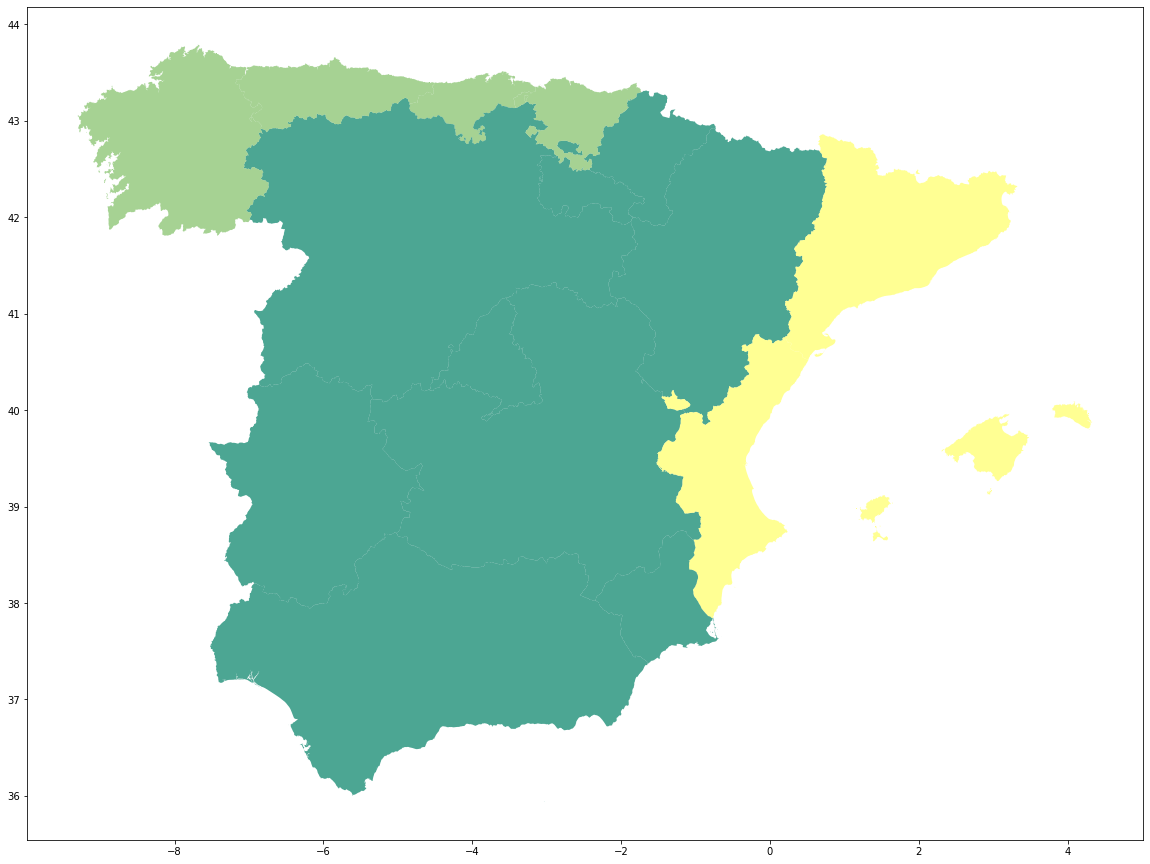

In [45]:
plt.rcParams["figure.figsize"]=20,20
my_map = espania.plot(column="GRUPO", linewidth=1, cmap="summer", k=8, alpha=0.7)

Cómo podemos observar, aunque indicamos 4 cluster, Canarias quedó en un cluster separado, de ahí que solo veamos 3 grupos.

Según nuestro modelo, parece ser que la alimentación en la zona norte y este de España varía del resto de españa.